In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy.random import multivariate_normal, permutation
import matplotlib.pyplot as plt

np.random.seed(20201229)
tf.set_random_seed(20201229)

In [3]:
# --- トイデータの生成 ---
def generate_datablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = pd.DataFrame(data, columns=['x1','x2'])
    df['t'] = t
    return df

df0 = generate_datablock(30, [-7,-7], 18, 1)
df1 = generate_datablock(30, [-7,7], 18, 0)
df2 = generate_datablock(30, [7,-7], 18, 0)
df3 = generate_datablock(30, [7,7], 18, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

In [5]:
train_x = train_set[['x1','x2']].values
train_t = train_set['t'].values.reshape([len(train_set), 1])

In [6]:
# --- ニューラルネットワークの設計 ---
num_units1 = 2
num_units2 = 2

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units1]))
b1 = tf.Variable(tf.zeros([num_units1]))
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1)

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(hidden1, w2) + b2)

w0 = tf.Variable(tf.zeros([num_units2, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden2, w0) + b0)

In [7]:
# --- 損失関数を定義 ---
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
# --- パラメータの最適化 ---
sess = tf.Session()
sess.run(tf.initialize_all_variables())
i = 0
for _ in range(2000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:train_x, t:train_t})
        print ('Step: %d, Loss: %f, Accuracy: %f' % (i, loss_val, acc_val))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step: 100, Loss: 82.845329, Accuracy: 0.533333
Step: 200, Loss: 82.623634, Accuracy: 0.533333
Step: 300, Loss: 81.805084, Accuracy: 0.533333
Step: 400, Loss: 73.916428, Accuracy: 0.708333
Step: 500, Loss: 52.188072, Accuracy: 0.925000
Step: 600, Loss: 35.368050, Accuracy: 0.958333
Step: 700, Loss: 28.373138, Accuracy: 0.958333
Step: 800, Loss: 25.124737, Accuracy: 0.958333
Step: 900, Loss: 23.393169, Accuracy: 0.958333
Step: 1000, Loss: 22.364775, Accuracy: 0.958333
Step: 1100, Loss: 21.702765, Accuracy: 0.958333
Step: 1200, Loss: 21.249750, Accuracy: 0.958333
Step: 1300, Loss: 20.924620, Accuracy: 0.958333
Step: 1400, Loss: 20.682215, Accuracy: 0.958333
Step: 1500, Loss: 20.495783, Accuracy: 0.958333
Step: 1600, Loss: 20.348637, Accuracy: 0.958333
Step: 1700, Loss: 20.229954, Accuracy: 0.958333
Step: 1800, Loss: 20.132425, Accuracy: 0.958333
Step: 1900, Loss: 20.050983, Accuracy: 0.958333
Step: 2000, Loss: 19.98

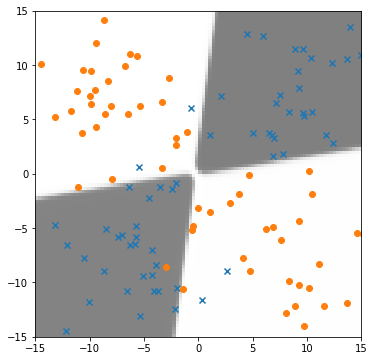

In [9]:
# --- 結果描画 ---
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([-15,15])
subplot.set_xlim([-15,15])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(-15,15,100):
    for x1 in np.linspace(-15,15,100):
        locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100, 100))
subplot.imshow(p_vals, origin='lower', extent=(-15,15,-15,15), cmap=plt.cm.gray_r, alpha=0.5)